
--- Model Comparison ---
                         Model          MAE          RMSE        R2  \
2  Gradient Boosting Regressor  2528.576674   3486.422060  0.989382   
3            XGBoost Regressor  2633.977170   3658.520664  0.988308   
1           AdaBoost Regressor  3996.924284   6127.042827  0.967207   
0            Linear Regression  9865.968743  17640.482984  0.728168   

   Adjusted R2  
2     0.989303  
3     0.988221  
1     0.966964  
0     0.726154  
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300, 'select__k': 10}
Best CV R² score: 0.9942034127017825
Selected features: ['Income (USD)', 'Profession', 'Location', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Expense Type 1', 'Credit Score', 'Property Age', 'Property Location', 'Property Price']


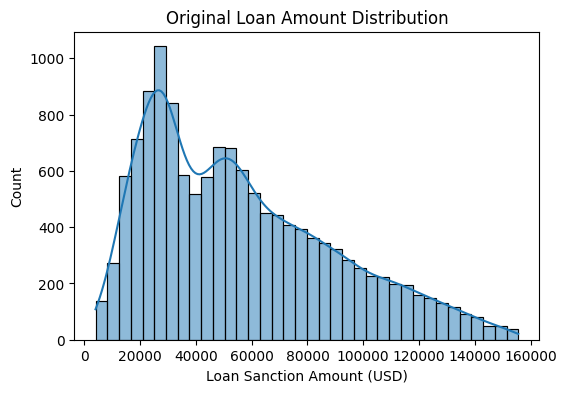

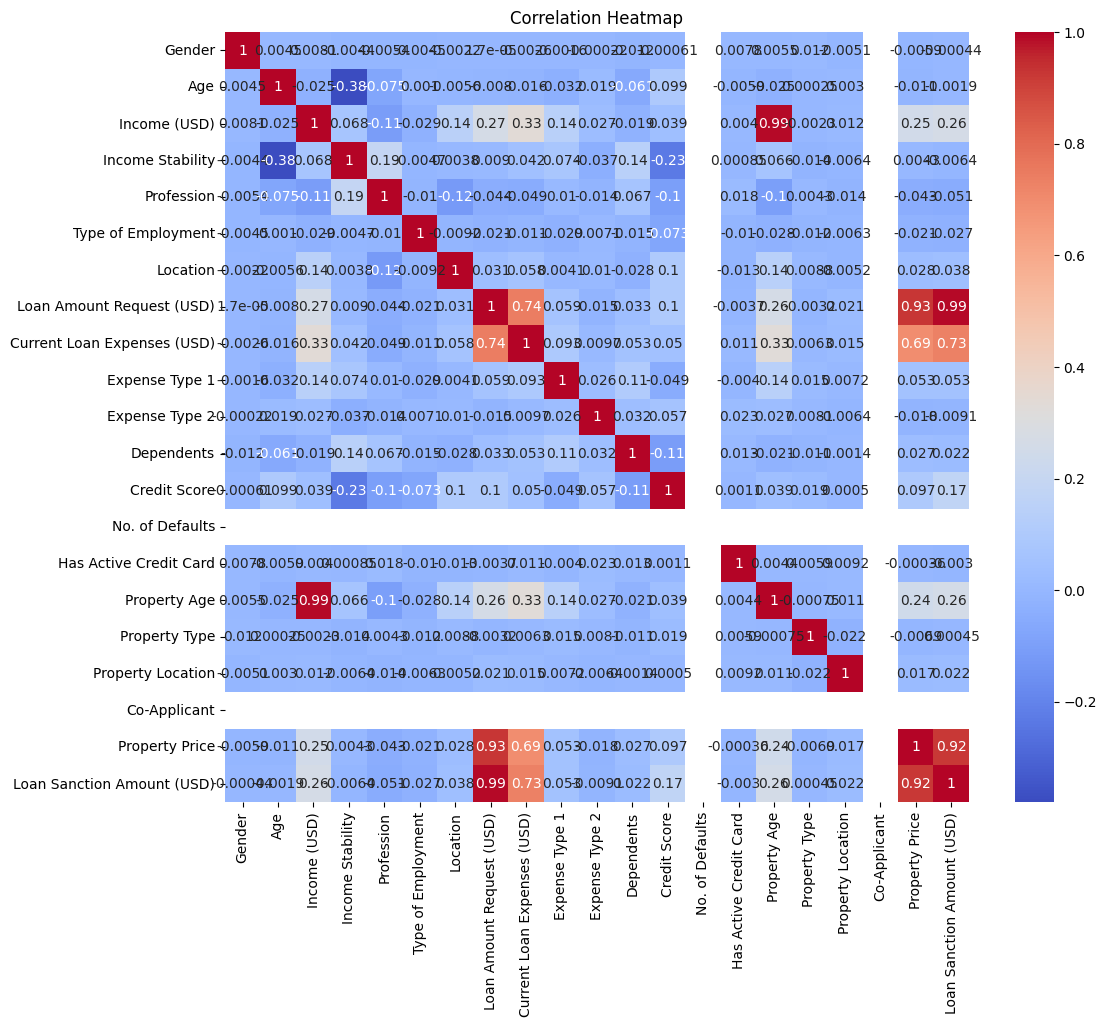

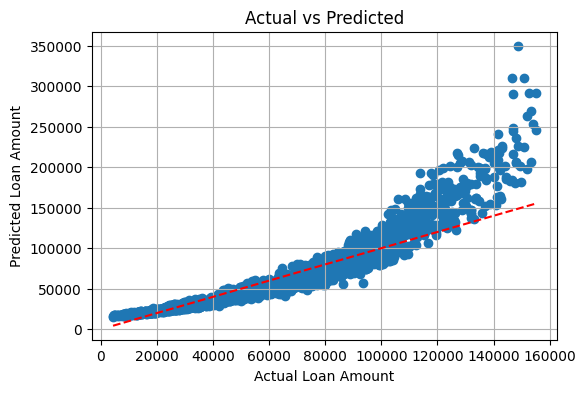

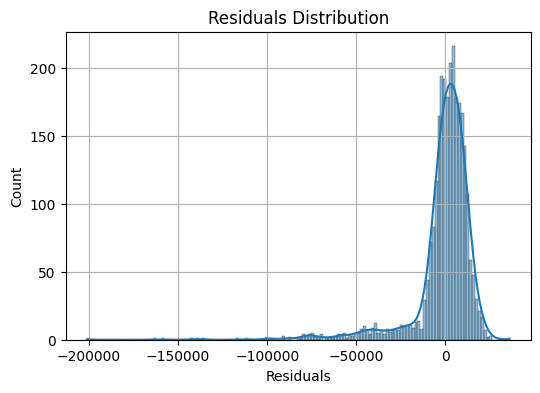

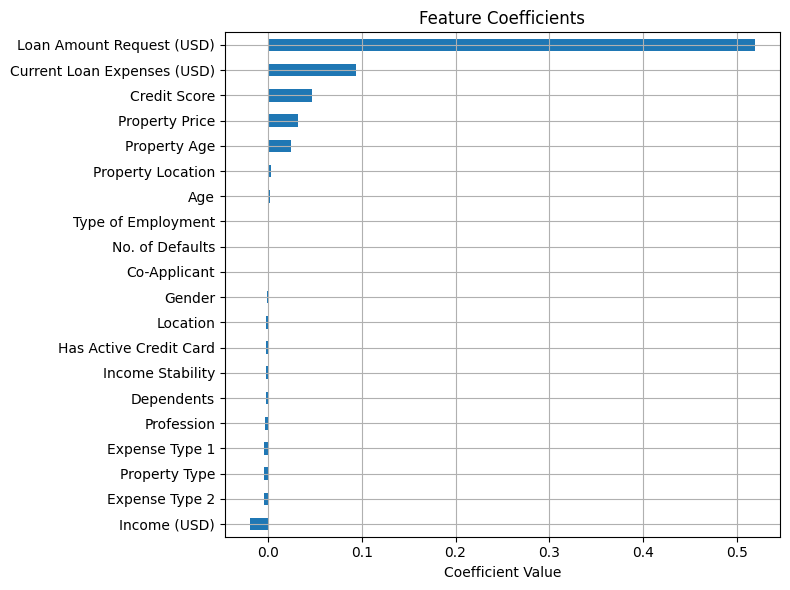


--- Cross-Validation (5-Fold) ---
Average MAE: 9351.87
Average MSE: 2812.64
Average RMSE: 12601.44
Average R2 Score: 0.8882


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv("train.csv")

# Drop rows with missing or invalid target
df = df[df["Loan Sanction Amount (USD)"].notnull()]
df = df[df["Loan Sanction Amount (USD)"] > 0]

# Keep only relevant features
selected_features = [
    'Gender', 'Age', 'Income (USD)', 'Income Stability', 'Profession',
    'Type of Employment', 'Location', 'Loan Amount Request (USD)',
    'Current Loan Expenses (USD)', 'Expense Type 1', 'Expense Type 2',
    'Dependents', 'Credit Score', 'No. of Defaults',
    'Has Active Credit Card', 'Property Age', 'Property Type',
    'Property Location', 'Co-Applicant', 'Property Price',
    'Loan Sanction Amount (USD)'
]
df = df[selected_features]

# =========================
# 2. Handle Missing Values
# =========================
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# =========================
# 3. Remove Outliers (IQR)
# =========================
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# =========================
# 4. Encode Categorical
# =========================
categorical_cols = df.select_dtypes(include='object').columns.tolist()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# =========================
# 5. Separate Features/Target
# =========================
X = df.drop("Loan Sanction Amount (USD)", axis=1)
y = df["Loan Sanction Amount (USD)"]

# Log transform target
y_log = np.log1p(y)

# =========================
# 6. Train/Test Split
# =========================
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# =========================
# 7. Standardize (keep DataFrame)
# =========================
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# =========================
# 8. Helper function
# =========================
results = []
def evaluate_model(name, model, X_train, X_test, y_train_log, y_test_log):
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(y_test_log)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    n, p = X_test.shape
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adjusted_r2
    })

# =========================
# 9. Model Evaluations
# =========================
evaluate_model("Linear Regression", LinearRegression(), X_train, X_test, y_train_log, y_test_log)
evaluate_model("AdaBoost Regressor", AdaBoostRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
               X_train, X_test, y_train_log, y_test_log)
evaluate_model("Gradient Boosting Regressor", GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                                                        max_depth=5, random_state=42),
               X_train, X_test, y_train_log, y_test_log)
evaluate_model("XGBoost Regressor", XGBRegressor(n_estimators=500, learning_rate=0.05,
                                                 max_depth=6, subsample=0.8, colsample_bytree=0.8,
                                                 random_state=42, reg_lambda=1, reg_alpha=0),
               X_train, X_test, y_train_log, y_test_log)

df_results = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\n--- Model Comparison ---")
print(df_results)

# =========================
# 10. Grid Search + Feature Selection
# =========================
pipe = Pipeline([
    ('select', SelectKBest(score_func=f_regression)),
    ('model', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'select__k': [5, 10, 15, 'all'],
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train_log)
print("Best parameters:", grid_search.best_params_)
print("Best CV R² score:", grid_search.best_score_)

# Get actual selected features
best_selector = grid_search.best_estimator_.named_steps['select']
selected_mask = best_selector.get_support()
selected_features = X_train.columns[selected_mask]
print("Selected features:", selected_features.tolist())

# =========================
# 11. Visualizations
# =========================
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Original Loan Amount Distribution")
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

model = LinearRegression().fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.grid(True)
plt.show()

coefficients = pd.Series(model.coef_, index=X.columns)
coefficients.sort_values().plot(kind='barh', figsize=(8, 6), title="Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 12. Cross-validation
# =========================
kf = KFold(n_splits=
           , shuffle=True, random_state=42)
mae_scores = cross_val_score(model, X_train, y_train_log, cv=kf, scoring='neg_mean_absolute_error')
mse_scores = cross_val_score(model, X_train, y_train_log, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=kf, scoring='r2')

print("\n--- Cross-Validation (5-Fold) ---")
print(f"Average MAE: {-mae_scores.mean() * df['Loan Sanction Amount (USD)'].mean():.2f}")
print(f"Average MSE: {-mse_scores.mean() * df['Loan Sanction Amount (USD)'].mean():.2f}")
print(f"Average RMSE: {np.sqrt(-mse_scores.mean()) * df['Loan Sanction Amount (USD)'].mean():.2f}")
print(f"Average R2 Score: {r2_scores.mean():.4f}")
